# Helper Functions

In [1]:
import sys
import os

cwd = os.getcwd()
root_path = os.path.abspath('..\..')
sys.path.insert(0, root_path)

print(sys.path)

['c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD\\analysis\\raw', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\python39.zip', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\DLLs', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad', '', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib\\site-packages', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib\\site-packages\\win32', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpa

In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils.enums import Perspective

In [3]:
def plot_losses(results, labels, directory, run_name, perspective, level, bucket=None, zoom=[[11000,13000],[-0.05, 0.2]], show_plots=True):
    def scatter_plot(ax, results, labels):
        y_values = results
        x_values = np.arange(len(results))
        ax.scatter(x_values[labels == 0], y_values[labels == 0], c='grey', s=3, label='Normal Prefixes', zorder=1)
        ax.scatter(x_values[labels == 1], y_values[labels == 1], c='red', s=3, label='Anomalous Prefixes', zorder=2)
        ax.grid(True)

    # Normalize results
    results = np.interp(results, (results.min(), results.max()), (0, 1))

    subtitle = f'{directory}     {run_name}'
    if len(results) == 0:
        print(f'ERROR no results found for {subtitle}')
    else:
        fig, ax = plt.subplots(figsize=(15, 6))

        labels = labels[:, perspective]
        scatter_plot(ax, results, labels)
        
        perspective_name = Perspective.values()[perspective]

        bucket_string = ''
        if bucket is not None:
            bucket_string = f'with bucket size {str(bucket)}'
        
        title = f'Error per Prefix on the {perspective_name} perspective at {level} level {bucket_string}'
        
        # Print to keep track of plotting
        # print(f'\t {title}')
        
        plt.title(f'{title}\n{subtitle}')
        plt.xlabel('Prefix Index')
        plt.ylabel('Loss')
        
        if zoom:
            axins = inset_axes(ax, width="60%", height="60%", loc='upper right')

            scatter_plot(axins, results, labels)
            axins.set_xlim(zoom[0])
            axins.set_ylim(zoom[1])
            _,_ = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=3)

        plt.xlabel('Case Index')
        plt.ylabel('Error')
        plt.legend(loc='upper right')
        
        plot_path = f"plots\{directory}\{run_name} "
        os.makedirs(plot_path, exist_ok=True)
        plt.savefig(f"{plot_path}\error_plots\{perspective_name}_{level}_{bucket_string}.png", format='png', dpi=300)
        
        if show_plots:
            plt.show()
        plt.close()

def bucket_plot_losses(results_name, labels_name, run_name, directory, bucket_lengths, results, perspective, level, zoom=[[11000,13000],[-0.05, 0.2]], show_plots=True, pbar=None):
    if bucket_lengths is None:
        plot_losses(
            results=results[f'{results_name}'], 
            labels=results[f'{labels_name}'],
            directory=directory,
            run_name=run_name, perspective=perspective, level=level, bucket=None, zoom=zoom, show_plots=show_plots)
        if pbar:
            pbar.update(1)       
    else:
        for bucket in bucket_lengths:
            plot_losses(
                results=results[f'{results_name}_{bucket}'], 
                labels=results[f'{labels_name}_{bucket}'],
                directory=directory,
                run_name=run_name, perspective=perspective, level=level, bucket=bucket, zoom=zoom, show_plots=show_plots)
            if pbar:
                pbar.update(1)  


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_score(data, score_type, level, ax, label_name, xlabel_name):
    subset = data[data["level"] == level]
    
    sns.lineplot(
        data=subset,
        x=label_name,
        y=score_type,
        hue="perspective",
        # style="categorical_encoding",
        markers=True,
        dashes=False,
        ax=ax
    )
    
    ax.set_title(f"{score_type.capitalize()} Scores (Level={level.capitalize()})")
    ax.set_xlabel(xlabel_name)
    ax.set_ylabel(f"{score_type.capitalize()}" if level=='trace' else "")
    ax.tick_params(axis="x", rotation=90)

def plot_scores(data, directory, title, label_name, xlabel_name, summary=True, filter_beginning_percentage=0, postfix=None):
    levels = ["trace", "event", "attribute"]
    
    if summary:
        fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=False)
    else:
        fig, axes = plt.subplots(6, 3, figsize=(18, 18), sharex=True, sharey=False)
    
    handles, labels = [], []

    for i, level in enumerate(levels):
        plot_single_score(data, "f1", level, axes[0, i], label_name, xlabel_name)
        plot_single_score(data, "run_time", level, axes[1, i], label_name, xlabel_name)
        if not summary:
            plot_single_score(data, "pr_auc", level, axes[2, i], label_name, xlabel_name)
            plot_single_score(data, "roc_auc", level, axes[3, i], label_name, xlabel_name)
            plot_single_score(data, "precision", level, axes[4, i], label_name, xlabel_name)
            plot_single_score(data, "recall", level, axes[5, i], label_name, xlabel_name)

        if not handles and not labels:
            handles, labels = axes[0, i].get_legend_handles_labels()
        
        axes[0, i].legend().remove()
        axes[1, i].legend().remove()
        if not summary:
            axes[2, i].legend().remove()
            axes[3, i].legend().remove()
            axes[4, i].legend().remove()
            axes[5, i].legend().remove()

    fig.legend(
        handles,
        labels,
        title="Perspective & Encoding",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=3
    )
    
    fig.suptitle(f'F1-Scores: {directory}: {title}', fontsize=16, fontweight='bold')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    plot_path = f"plots\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    if postfix is not None:
        plt.savefig(f"{plot_path}\experimental_results_{title}_{postfix}_{filter_beginning_percentage}.png", format='png', dpi=300, bbox_inches="tight")
    else:
        plt.savefig(f"{plot_path}\experimental_results_{title}_{filter_beginning_percentage}.png", format='png', dpi=300, bbox_inches="tight")

    plt.show()

# Config

In [5]:
# 'Experiment_Real_World_Debug',
# 'Experiment_Prefix_v2',

directories = [
    'Experiment_Transformer_Debug_67768'
    # 'Experiment_Prefix_v3',
    # 'Experiment_Batch_Size',
    # 'Experiment_Anomaly_Percentage_v2',
    # 'Experiment_Synthetic_Dataset_v4',

    # 'Experiment_Finetuning_Fixed_Vector_Vector_Sizes',
    # 'Experiment_Finetuning_T2V_Window_Vector_Sizes',
    # 'Experiment_Finetuning_W2V_Window_Vector_Sizes',

    # 'Experiment_Synthetic_All_Models',
    # 'Experiment_Real_World_All_Models',
    ] 

filter_beginning_percentage = 0

recalculate = True

score_results = True
score_summary = True

rank_encoders = True
rank_cd_encoders = True

plot_results = True
show_plots = True


In [6]:
directory = directories[-1]
print(directory)

Experiment_Transformer_Debug_67768


In [7]:
from analysis.raw.utils.load_data import list_subfolders_or_zip_files


run_list = list_subfolders_or_zip_files(directory)
print(run_list)
print(run_list[0])

['24-12-19-21-17_Transformer_Tokenizer_42924.zip']
24-12-19-21-17_Transformer_Tokenizer_42924.zip


# Loading Runs

In [8]:
from analysis.raw.utils.load_data import load_score_dataframe

score_path = f"plots\{directory}\\"
score_file = f"scores_raw_df_{filter_beginning_percentage}.pkl"
all_scores_df = None

# Check if scores_raw_df.pkl exists and if yes skip reloading all data, force recalculation if set to true
if not recalculate:
    all_scores_df = load_score_dataframe(score_path + score_file)

In [9]:
# If needed to merge two score dataframes
# directory_2 = 'Experiment_Real_World_All_Models_T2V_C'
# score_path_2 = f"plots\{directory_2}\\"

# if not recalculate:
#     all_scores_df_2 = load_score_dataframe(score_path_2 + score_file)
# result = pd.concat([all_scores_df, all_scores_df_2], axis=0, ignore_index=True)

# print(all_scores_df.shape)
# print(all_scores_df_2.shape)
# print(result.shape)

# os.makedirs(score_path, exist_ok=True)
# result.to_pickle(score_path + score_file)

In [10]:
from analysis.raw.utils.load_data import cleanup_temp_folders, get_buckets, load_config, load_results, unzip_results
from analysis.raw.utils.process_raw_data import score


runs = []
scores_dfs = []
total_runtime = 0

# If no scores_raw_df.pkl exists, recalulate is true or plotting individual runs start loading all data from raw
if all_scores_df is None or recalculate is True or plot_results is True:
    for index, run_name in enumerate(tqdm(run_list)):
        # try:
            # If needed unzip the data
            run_name, from_zip = unzip_results(directory, run_name)

            # Loading the data
            results = load_results(run_name=run_name, directory=directory)
            config = load_config(run_name=run_name, directory=directory)
            buckets = get_buckets(results.keys())
            timestamp = run_name.split('_')[0]

            total_runtime += config['run_time']

            # If needed clean up temp folder
            if from_zip:
                cleanup_temp_folders(directory, run_name)
            
            # If set filter the first % of results from the run to allow the scoring some grace period
            if filter_beginning_percentage != 0:
                for key, value in results.items():
                    filter_index = int(value.shape[0] / filter_beginning_percentage)
                    # print(filter_index)
                    results[key] = value[filter_index:]


            run = {
                "name": run_name,
                "timestamp": timestamp,
                "results": results,
                "config": config,
                "buckets": buckets,
                "index": index,
            }

            # If no preloaded scores exist
            if (all_scores_df is None or recalculate is True) and (score_results is True or rank_encoders is True or rank_cd_encoders is True): 
                scores_df = score(run=run)
                scores_dfs.append(scores_df)

            # Only save to runs if plotting results otherwise it is wasting memory
            if plot_results:
                runs.append(run)
        # except Exception as e:
        #     print(f"Failed to load: {run_name}")
        #     print(e)

print(len(scores_dfs))
# Save the scores dataframe to disk if it has calculated
if len(scores_dfs) != 0:
    all_scores_df = pd.concat(scores_dfs, ignore_index=True)
    os.makedirs(score_path, exist_ok=True)
    all_scores_df.to_pickle(score_path + score_file)

print(len(runs))

  0%|          | 0/1 [00:00<?, ?it/s]

perspective_label_indices {0: [0], 1: [1, 2, 3, 4]}
results dict_keys(['labels_Transformer_attribute', 'labels_Transformer_event', 'labels_Transformer_trace', 'losses_Transformer', 'result_Transformer_attribute_Attribute', 'result_Transformer_attribute_Order', 'result_Transformer_event_Attribute', 'result_Transformer_event_Order', 'result_Transformer_trace_Attribute', 'result_Transformer_trace_Order'])
key labels_Transformer_attribute
key labels_Transformer_event
key labels_Transformer_trace
key losses_Transformer
key result_Transformer_attribute_Attribute
key result_Transformer_attribute_Order
key result_Transformer_event_Attribute
key result_Transformer_event_Order
key result_Transformer_trace_Attribute
key result_Transformer_trace_Order
trace 2
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
trace 3
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
event 0
Found input variables with inconsistent numbers of samples: [465803, 35831

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

attribute 0
Found input variables with inconsistent numbers of samples: [465803, 35831]
attribute 1
Found input variables with inconsistent numbers of samples: [1863212, 143324]
attribute 2
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
attribute 3
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
1
1


In [11]:
if total_runtime != 0:
    output = f"Total runtime (multiple scales): \n{round(total_runtime / 3600, 2)} hours \n{round(total_runtime / 60, 2)} minutes \n{round(total_runtime, 2)} seconds"

    plot_path = f"plots\\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    file_path = f"{plot_path}\\total_runtime.txt"

    with open(file_path, 'w') as file:
        file.write(output)

In [12]:
all_scores_df

,run_name,model,dataset,timestamp,index,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size
0,Experiment_Transformer_Debug_67768,Transformer,process_log_24-11-21-11-44_medium_0.45_4_1.jso...,24-12-19-21-17,0,trace,Order,0.522361,0.183738,0.290261,0.214324,0.144946,432.384965,32,True,None,Tokenizer,Min Max Scaling,0,0
1,Experiment_Transformer_Debug_67768,Transformer,process_log_24-11-21-11-44_medium_0.45_4_1.jso...,24-12-19-21-17,0,trace,Attribute,0.533276,0.196216,0.317833,0.202706,0.209459,432.384965,32,True,None,Tokenizer,Min Max Scaling,0,0


In [13]:
print(all_scores_df.shape)
all_scores_df = all_scores_df.drop(columns=["run_name", "timestamp", "index", "numerical_encoding"])
all_scores_df["buckets"] = all_scores_df["buckets"].astype(str)
print(all_scores_df.shape)

(2, 20)
(2, 16)


In [14]:
all_scores_df.head(1)

,model,dataset,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size
0,Transformer,process_log_24-11-21-11-44_medium_0.45_4_1.jso...,trace,Order,0.522361,0.183738,0.290261,0.214324,0.144946,432.384965,32,True,None,Tokenizer,0,0


# Plot Results

In [15]:
if plot_results:
    results_config = [
        ('result_DAE_trace_Order', 'labels_DAE_trace', Perspective.ORDER, 'trace'),
        ('result_DAE_trace_Attribute', 'labels_DAE_trace', Perspective.ATTRIBUTE, 'trace'),
        ('result_DAE_trace_Arrival Time', 'labels_DAE_trace', Perspective.ARRIVAL_TIME, 'trace'),
        ('result_DAE_trace_Workload', 'labels_DAE_trace', Perspective.WORKLOAD, 'trace'),
    ]

    nr_buckets = 0
    for run in runs:
        if run["buckets"] is None:
            nr_buckets += 1
        else:
            nr_buckets += len(run["buckets"])

    total_iterations = nr_buckets * len(results_config)
    with tqdm(total=total_iterations, desc="Generating Plots") as pbar:
        for run in runs:
            # print(f"Generating: {directory}\t{run_name}")
            for config in results_config:
                
                # try:
                bucket_plot_losses(
                    results_name=config[0], 
                    labels_name=config[1],
                    directory=directory,
                    run_name=run["name"],
                    bucket_lengths=run["buckets"],
                    results=run["results"],
                    perspective=config[2],
                    level=config[3],
                    zoom=None,
                    show_plots=show_plots,
                    pbar=pbar)
                # except:
                #     print("Error loading ")


Generating Plots:   0%|          | 0/4 [00:00<?, ?it/s]


KeyError: 'result_DAE_trace_Order'

# Score Results

In [97]:
# Generate additional rows for the encoding methods combined
group_cols = [
    "model", "dataset", "level", "perspective", "batch_size", "vector_size", "window_size", "prefix", "buckets"
]

averages_methods = (
    all_scores_df.groupby(group_cols)
    .agg({
        "roc_auc": "mean", 
        "pr_auc": "mean", 
        "f1": "mean", #["mean", "std"],
        "precision": "mean", 
        "recall": "mean",
        "run_time": "mean", #["mean", "std"]
    })
)

# averages_methods.columns = ['_'.join(col).strip('_') for col in averages_methods.columns]
averages_methods = averages_methods.reset_index()

averages_methods["categorical_encoding"] = "All"
# averages_methods["timestamp"] = "Average"

result_methods_df = pd.concat([all_scores_df, averages_methods], ignore_index=True)

In [98]:
averages_methods.head(1)

,model,dataset,level,perspective,batch_size,vector_size,window_size,prefix,buckets,roc_auc,pr_auc,f1,precision,recall,run_time,categorical_encoding
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Arrival Time,8,0,0,False,None,0.580501,0.002635,0.006648,0.002499,0.580291,33.19549,All


In [99]:
print(all_scores_df.shape)
print(averages_methods.shape)
print(result_methods_df.shape)

(30636, 16)
(3264, 16)
(33900, 16)


In [100]:
# Generate additional rows for the perspectives combined
group_cols = [
    "model", "dataset", "level", "categorical_encoding", "batch_size", "vector_size", "window_size", "prefix", "buckets"
]
averages_perspective = (
    result_methods_df.groupby(group_cols)
    .agg({
        "roc_auc": "mean", 
        "pr_auc": "mean", 
        "f1": "mean", 
        "precision": "mean", 
        "recall": "mean",
        "run_time": "mean"
    })
)

# averages_perspective.columns = ['_'.join(col).strip('_') for col in averages_perspective.columns]
averages_perspective = averages_perspective.reset_index()

averages_perspective["perspective"] = "All"


result_df = pd.concat([result_methods_df, averages_perspective], ignore_index=True)

In [101]:
print(result_methods_df.shape)
print(averages_perspective.shape)
print(result_df.shape)

(33900, 16)
(1632, 16)
(35532, 16)


In [102]:
result_df.head(5)

,model,dataset,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.614518,0.063084,0.087912,0.023163,0.612735,21.670184,8,False,None,One Hot,0,0
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Attribute,0.501694,0.016757,0.043011,0.016140,0.501567,21.670184,8,False,None,One Hot,0,0
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Arrival Time,0.487257,0.019959,0.043892,0.019357,0.487527,21.670184,8,False,None,One Hot,0,0
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Workload,0.645332,0.403972,0.427264,0.522276,0.310704,21.670184,8,False,None,One Hot,0,0
4,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,event,Order,0.537545,0.001873,0.008114,0.001754,0.537608,21.670184,8,False,None,One Hot,0,0


In [103]:
# Generate additional columns used in analysis
result_df["dataset_size"] = result_df["dataset"].str.split('_').str[3]
result_df["anomaly_percentage"] = result_df["dataset"].str.split('_').str[4]
result_df["anomaly_percentage"] = result_df["anomaly_percentage"].astype(float)
result_df["batch_size"] = result_df["batch_size"].astype(str)
result_df["vector_size"] = result_df["vector_size"].astype(str)
result_df["vector_window_size"] = result_df["vector_size"].astype(str) + '/' + result_df["window_size"].astype(str)
# result_df["prefix"] = result_df["prefix"].astype(str)
result_df["prefix"] = np.where(
    result_df["prefix"].astype(bool), 
    "Prefix", 
    "No Prefix"
)
result_df["buckets"] = np.where(
    result_df["buckets"].astype(str) == "None", 
    "No Bucketing", 
    "Bucketing"
)
result_df["prefix_buckets"] = result_df["prefix"].astype(str) + '/' + result_df["buckets"].astype(str)

In [104]:
result_df.shape

(35532, 20)

In [105]:
result_df.tail(1)

,model,dataset,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size,dataset_size,anomaly_percentage,vector_window_size,prefix_buckets
35531,DAE,process_log_24-11-21-12-07_wide_0.4_4_8.json.gz,trace,All,0.61158,0.22512,0.329913,0.212406,0.60334,66.024783,8,Prefix,Bucketing,Word2Vec Average Then Concatinate,160,2,wide,0.4,160/2,Prefix/Bucketing


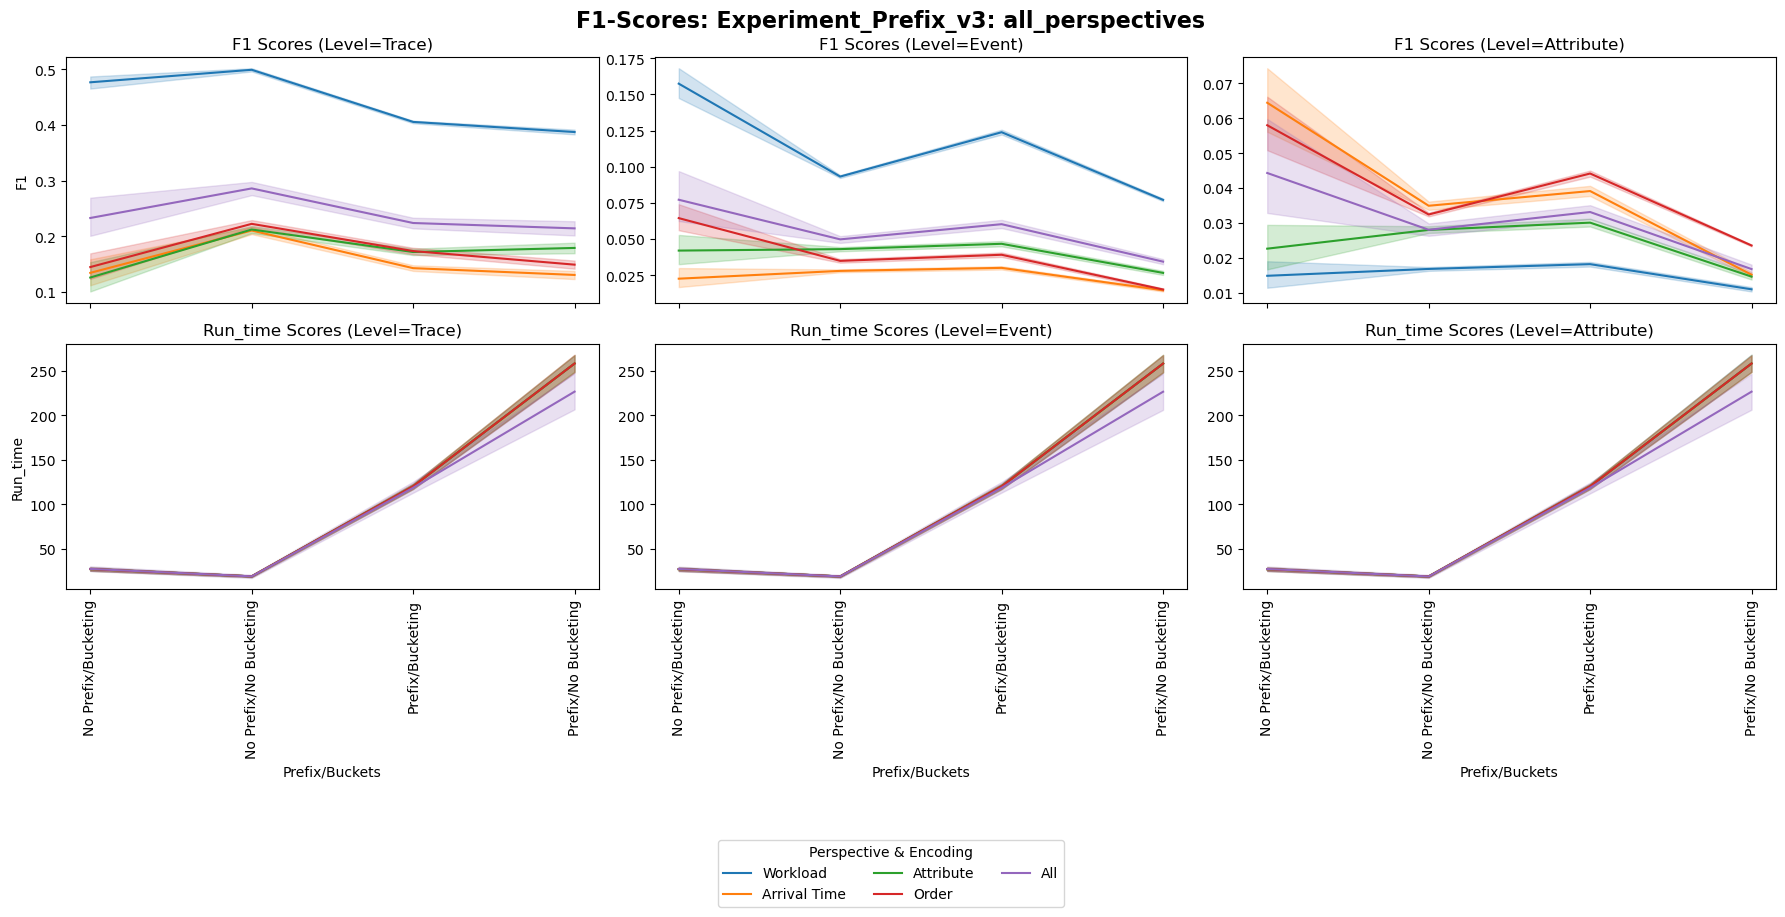

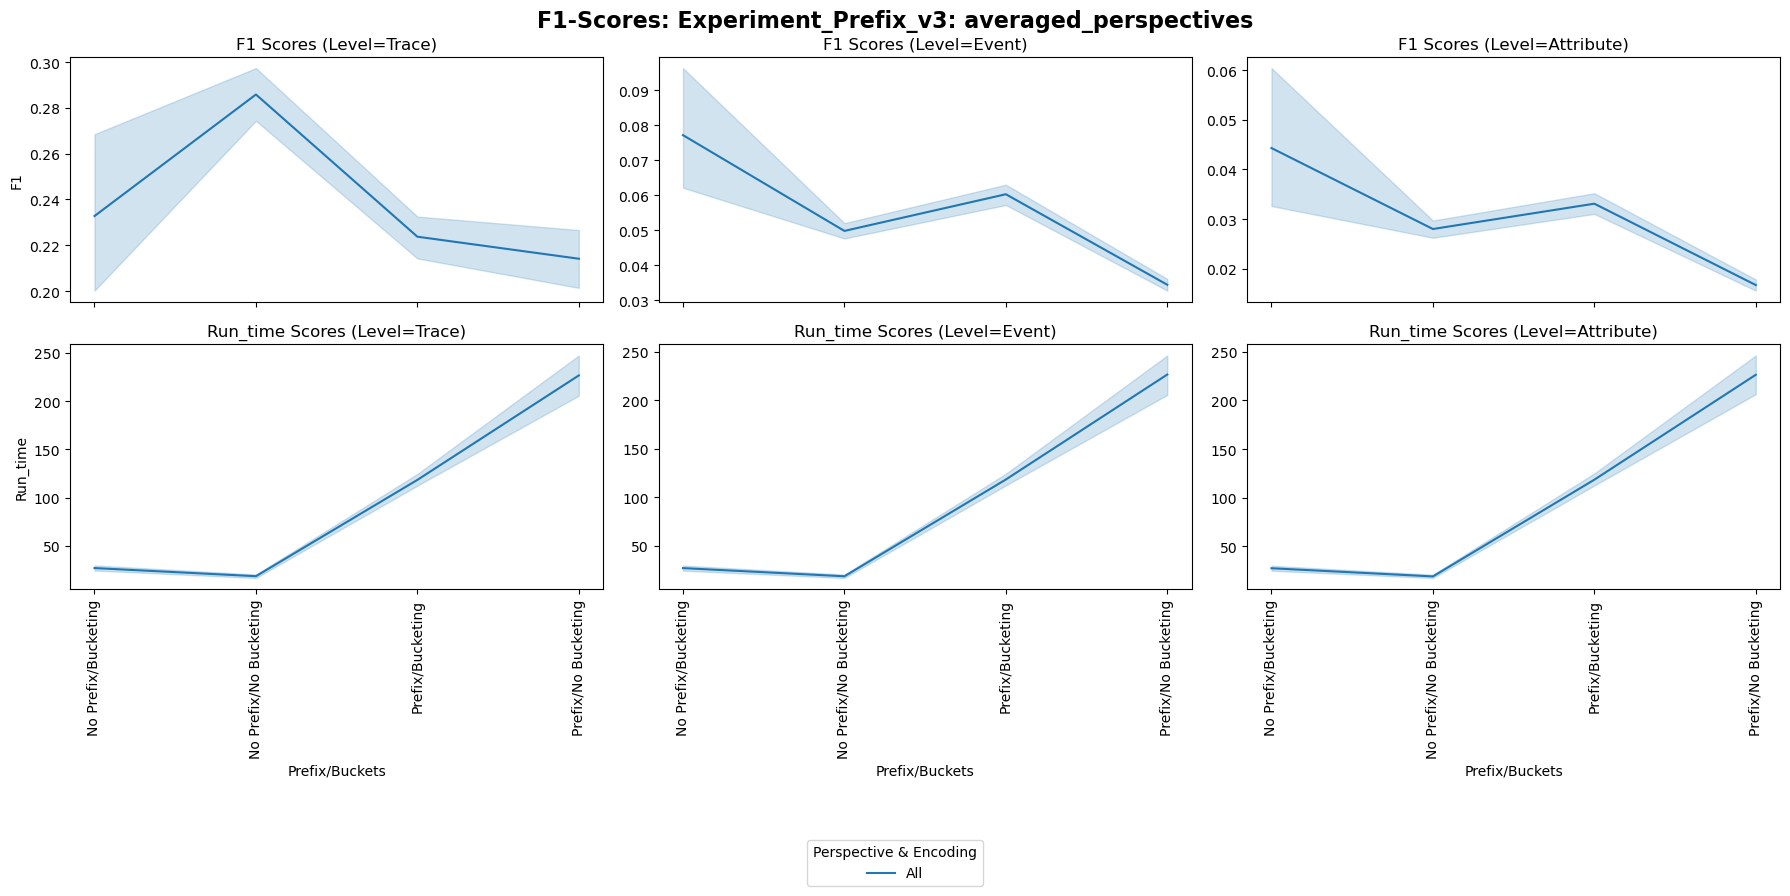

In [106]:
if score_results:
    if "Experiment_Anomaly_Percentage" in directory:
        xlabel_name="Anomaly Percentages"
        label_name="anomaly_percentage"
        plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

    elif "Experiment_Synthetic_Dataset" in directory:
        xlabel_name="Dataset Sizes"
        label_name="dataset_size"
        plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

    elif "Experiment_Batch_Size" in directory:
        xlabel_name="Batch Sizes"
        label_name="batch_size"
        plot_scores(result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(result_df[result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

    elif "Experiment_Prefix_v3" in directory:
        xlabel_name="Prefix/Buckets"
        label_name="prefix_buckets"

        sorted_result_df = result_df.sort_values(by=label_name, ascending=True, inplace=False)

        plot_scores(sorted_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(sorted_result_df[sorted_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
    
    elif "Experiment_Finetuning_Fixed_Vector_Vector_Sizes" in directory:
        filtered_result_df = result_df[result_df["categorical_encoding"] == "Fixed Vector"]

        xlabel_name="Vector Sizes"
        label_name="vector_size"

        plot_scores(filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)  

    elif "Experiment_Finetuning_T2V_Window_Vector_Sizes" in directory:
        atc_filtered_result_df = result_df[result_df["categorical_encoding"] == "Trace2Vec Average Then Concatinate"]
        c_filtered_result_df = result_df[result_df["categorical_encoding"] == "Trace2Vec Concatinate"]

        xlabel_name="Vector/Window Sizes ATC"
        label_name="vector_window_size"
        plot_scores(atc_filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='ATC')
        plot_scores(atc_filtered_result_df[atc_filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='ATC')
        xlabel_name="Vector/Window Sizes C"
        plot_scores(c_filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='C')
        plot_scores(c_filtered_result_df[c_filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='C')      
        
    elif "Experiment_Finetuning_W2V_Window_Vector_Sizes" in directory:
        atc_filtered_result_df = result_df[result_df["categorical_encoding"] == "Word2Vec Average Then Concatinate"]
        c_filtered_result_df = result_df[result_df["categorical_encoding"] == "Word2Vec Concatinate"]

        xlabel_name="Vector/Window Sizes ATC"
        label_name="vector_window_size"
        plot_scores(atc_filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='ATC')
        plot_scores(atc_filtered_result_df[atc_filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='ATC')
        xlabel_name="Vector/Window Sizes C"
        plot_scores(c_filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='C')
        plot_scores(c_filtered_result_df[c_filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='C')  

    elif "Experiment_Real_World_All_Models" in directory:
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["categorical_encoding"].unique())

        xlabel_name="Categorical Encoding"
        label_name="categorical_encoding"
        plot_scores(filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)  

    elif "Experiment_Synthetic_All_Models" in directory:
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["categorical_encoding"].unique())

        xlabel_name="Categorical Encoding"
        label_name="categorical_encoding"
        plot_scores(filtered_result_df, directory, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "All"], directory, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)  

# Rank Encoders

In [107]:
all_scores_df["dataset_short_name"] = all_scores_df["dataset"].str.split('_').str[3] + "/" + all_scores_df["dataset"].str.split('_').str[4]
all_scores_df["prefix_boolean"] = np.where(
    all_scores_df["prefix"].astype(bool), 
    "Prefix", 
    "No Prefix"
)
all_scores_df["buckets_boolean"] = np.where(
    all_scores_df["buckets"].astype(str) == "None", 
    "No Bucketing", 
    "Bucketing"
)
all_scores_df["prefix_buckets"] = all_scores_df["prefix_boolean"].astype(str) + '/' + all_scores_df["buckets_boolean"].astype(str)

In [108]:
all_scores_df.head(1)

,model,dataset,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size,dataset_short_name,prefix_boolean,buckets_boolean,prefix_buckets
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.614518,0.063084,0.087912,0.023163,0.612735,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing


In [109]:
def calculate_grouped_levels(df, group_by_index='dataset_short_name', rank_groupby_index='categorical_encoding'):
    grouped_all_levels = (
        df.groupby([group_by_index, rank_groupby_index, 'level'])[['f1']]
        .agg(['mean', 'std'])
        .reset_index()
    )
    # print(grouped_all_levels.shape)

    grouped_combined_levels = (
        df.groupby([group_by_index, rank_groupby_index])[['f1']]
        .agg(['mean', 'std'])
        .reset_index()
    )
    grouped_combined_levels['level'] = 'combined'
    # print(grouped_combined_levels.shape)
    
    grouped_levels = pd.concat([grouped_all_levels, grouped_combined_levels], axis=0, ignore_index=True)
    grouped_levels.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in grouped_levels.columns]
    # print(grouped_levels.shape)

    grouped_levels['f1_rank'] = grouped_levels.groupby([group_by_index, 'level'])['f1_mean'].rank(ascending=False)
    # print(grouped_levels.shape)

    return grouped_levels

In [110]:
grouped_levels = calculate_grouped_levels(all_scores_df)

In [111]:
plot_path = f"plots\{directory}"
os.makedirs(plot_path, exist_ok=True)

grouped_levels.to_csv(f'{plot_path}\grouped_rank_stats.csv', index=False) 

In [112]:
def calcualte_rank_stats(df, group_by_index=['categorical_encoding', 'level']):
    rank_stats_df = (
        df.groupby(group_by_index)
        .agg(
            rank_mean=('f1_rank', 'mean'),
            rank_std=('f1_rank', 'std'),
            f1_mean=('f1_mean', 'mean'),
            f1_std=('f1_mean', 'std')
        )
        .reset_index()
    )

    rank_stats_df['rank_std'] = rank_stats_df['rank_std'].fillna(0)
    rank_stats_df['f1_std'] = rank_stats_df['f1_std'].fillna(0)

    rank_stats_df['rank_mean'] = rank_stats_df['rank_mean'].round(2)
    rank_stats_df['rank_std'] = rank_stats_df['rank_std'].round(2)
    rank_stats_df['f1_mean'] = rank_stats_df['f1_mean'].round(2)
    rank_stats_df['f1_std'] = rank_stats_df['f1_std'].round(2)

    if len(group_by_index) == 2:
        rank_stats_df = rank_stats_df.sort_values(by=['level', 'rank_mean'], ascending=[True, True])
    else:
        rank_stats_df = rank_stats_df.sort_values(by=['rank_mean'], ascending=[True])
        
    return rank_stats_df

In [113]:
rank_stats_df = calcualte_rank_stats(grouped_levels)

In [114]:
rank_stats_df

,categorical_encoding,level,rank_mean,rank_std,f1_mean,f1_std
4,Word2Vec Average Then Concatinate,attribute,1.07,0.26,0.03,0.01
0,One Hot,attribute,1.93,0.26,0.03,0.01
5,Word2Vec Average Then Concatinate,combined,1.00,0.00,0.12,0.04
1,One Hot,combined,2.00,0.00,0.11,0.04
6,Word2Vec Average Then Concatinate,event,1.02,0.14,0.06,0.02
2,One Hot,event,1.98,0.14,0.05,0.02
7,Word2Vec Average Then Concatinate,trace,1.06,0.23,0.26,0.08
3,One Hot,trace,1.94,0.23,0.25,0.08


In [115]:
plot_path = f"plots\{directory}"
os.makedirs(plot_path, exist_ok=True)

rank_stats_df.to_csv(f'{plot_path}\summarised_rank_stats.csv', index=False) 

## Naive Rank

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

if rank_encoders:
    sns.set_theme(style="white")
    g = sns.FacetGrid(grouped_levels, col="level", sharey=True, sharex=False, height=5, aspect=1.5, col_wrap=2)

    g.map_dataframe(
        sns.lineplot,
        x="dataset_short_name",
        y="f1_rank",
        hue="categorical_encoding",
        marker="o"
    )

    g.set_axis_labels("Dataset", "Rank (1 = Best)")
    g.set_titles("Level: {col_name}")
    plt.subplots_adjust(top=0.85)
    g.figure.suptitle(f"{directory}: Ranking of Categorical Encodings methods per Dataset and Level", fontsize=16)

    # for ax in g.axes.flatten():
    #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    #     ax.grid(False)

    for ax in g.axes.flatten():
        # Get the current tick positions and labels
        tick_positions = ax.get_xticks()
        tick_labels = ax.get_xticklabels()

        # Set the ticks and labels explicitly with rotation
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')

        ax.grid(False)  # Turn off gridlines
        
    g.add_legend(title="Categorical Encoding", loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()

    plot_path = f"plots\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(f"{plot_path}\encoding_ranking_per_dataset.png", format='png', dpi=300, bbox_inches="tight")

    plt.show()

In [117]:
import matplotlib.pyplot as plt
import os

def plot_rankings(data_df, title, rank_column='rank_mean', error_column='rank_std', sharey=True):
    levels = ['combined', 'trace', 'event', 'attribute']
    fig, axes = plt.subplots(1, len(levels), figsize=(15, 4), sharey=sharey)

    for i, level in enumerate(levels):
        ax = axes[i]
        level_data = data_df[data_df['level'] == level]
        
        level_data_sorted = level_data.sort_values(rank_column)
        ordered_categories = level_data_sorted['categorical_encoding']
        y_values = level_data_sorted[rank_column]
        errors = level_data_sorted[error_column]

        ax.bar(
            ordered_categories, 
            y_values, 
            yerr=errors,
            color='skyblue', 
            capsize=5,
            alpha=0.9
        )

        ax.set_title(f"Level: {level}")
        if i == 0:
            ax.set_ylabel("Average Rank (Lower = Better)")
        ax.tick_params(axis="x", rotation=90)
        ax.grid(False)
        ax.grid(axis='y', linestyle='--', color='gray', alpha=0.5)

    plt.subplots_adjust(top=0.85)
    fig.suptitle(f"{title}: Average {rank_column} with Uncertainty Margins per Level", fontsize=16)

    plot_path = f"plots/{directory}"
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(f"{plot_path}/encoding_rankings_summary_{rank_column}.png", format='png', dpi=300, bbox_inches="tight")

    plt.show()


In [118]:
if rank_encoders:
    plot_rankings(rank_stats_df, title='Rank', rank_column='rank_mean', error_column='rank_std', sharey=True)
    plot_rankings(rank_stats_df, title='F1', rank_column='f1_mean', error_column='f1_std', sharey=False)

# Critical Difference Rank

In [119]:
import Orange

def generate_cd_plot(rank_stats, level, nr_datasets, perspective, plot_path, group_by_index, sub_filter_encoding):
    rank_stats_lvl = rank_stats # rank_stats[rank_stats["level"] == level]
    names = rank_stats_lvl[group_by_index].to_list()
    avranks = rank_stats_lvl['rank_mean'].to_list()
    if sub_filter_encoding:
        filename = f"{plot_path}/CD_{sub_filter_encoding}_{perspective}_{level}.png"
    else:
        filename = f"{plot_path}/CD_{perspective}_{level}.png"

    # https://github.com/biolab/orange3/blob/e2282bbe2cf3d30ba41220ea2df0b79201ca430c/Orange/evaluation/scoring.py
    # Choosing Nemenyi as no method is seen as the baseline to which all others are compared
    cd = Orange.evaluation.scoring.compute_CD(avranks=avranks, n=nr_datasets, alpha="0.05", test='nemenyi')
    # print(cd)
    Orange.evaluation.scoring.graph_ranks(avranks=avranks, names=names, cd=cd, width=10, textspace=3.2, reverse=True, filename=filename)

In [120]:
from math import floor

def calculate_nr_repeats(df, group_by_index='dataset_short_name', rank_groupby_index='categorical_encoding'):
    unique_combinations = df[[group_by_index, rank_groupby_index, 'level','perspective']].drop_duplicates()
    return floor(df.shape[0]/len(unique_combinations))

In [121]:
all_scores_df

,model,dataset,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size,dataset_short_name,prefix_boolean,buckets_boolean,prefix_buckets
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.614518,0.063084,0.087912,0.023163,0.612735,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Attribute,0.501694,0.016757,0.043011,0.016140,0.501567,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Arrival Time,0.487257,0.019959,0.043892,0.019357,0.487527,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Workload,0.645332,0.403972,0.427264,0.522276,0.310704,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
4,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,event,Order,0.537545,0.001873,0.008114,0.001754,0.537608,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30631,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,event,Workload,0.610082,0.034857,0.087641,0.045986,0.273266,89.827215,8,True,None,One Hot,0,0,p2p/0.45,Prefix,No Bucketing,Prefix/No Bucketing
30632,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,attribute,Order,0.453699,0.013831,0.031990,0.013120,0.454031,89.827215,8,True,None,One Hot,0,0,p2p/0.45,Prefix,No Bucketing,Prefix/No Bucketing
30633,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,attribute,Attribute,0.607136,0.010834,0.027253,0.012603,0.339295,89.827215,8,True,None,One Hot,0,0,p2p/0.45,Prefix,No Bucketing,Prefix/No Bucketing
30634,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,attribute,Arrival Time,0.542403,0.014359,0.029858,0.014249,0.503522,89.827215,8,True,None,One Hot,0,0,p2p/0.45,Prefix,No Bucketing,Prefix/No Bucketing


In [122]:
sub_filter_encodings = [None]
if "Experiment_Anomaly_Percentage" in directory:
    level_groupby_index =  'categorical_encoding'
    rank_groupby_index = 'dataset_short_name'
elif "Experiment_Finetuning_T2V_Window_Vector_Sizes" in directory or "Experiment_Finetuning_W2V_Window_Vector_Sizes" in directory or "Experiment_Finetuning_Fixed_Vector_Vector_Sizes" in directory:
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'categorical_encoding'
    sub_filter_encodings = all_scores_df["categorical_encoding"].unique()
    all_scores_df["categorical_encoding"] = all_scores_df["categorical_encoding"] + "[" + all_scores_df["vector_size"].astype(str) + "," + all_scores_df["window_size"].astype(str) + "]"
elif "Experiment_Finetuning_Fixed_Vector_Vector_Sizes" in directory:
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'categorical_encoding'
    sub_filter_encodings = all_scores_df["categorical_encoding"].unique()
    all_scores_df["categorical_encoding"] = all_scores_df["categorical_encoding"] + "[" + all_scores_df["vector_size"].astype(str) + "]"
elif "Experiment_Prefix_v3" in directory:
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'prefix_buckets'    
else: # Default to rank by encoder unless otherwise specified
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'categorical_encoding'

# print(sub_filter_encodings)
# print(all_scores_df["categorical_encoding"].unique())

if rank_cd_encoders:
    plot_path = f"plots/{directory}/CD_ranking"
    os.makedirs(plot_path, exist_ok=True)

    # Effective number of datasets because the critical difference depends on the total number of test results, not necessarily their source.
    nr_datasets = len(all_scores_df[level_groupby_index].unique()) * calculate_nr_repeats(all_scores_df)
    print(nr_datasets)
    perspectives = all_scores_df['perspective'].unique()
    perspectives = np.append(perspectives, 'All')

    levels = ["combined", "trace", "event", "attribute"]
    for sub_filter_encoding in sub_filter_encodings:
        if sub_filter_encoding is not None:
            all_scores_df_filtered = all_scores_df[all_scores_df['categorical_encoding'].str.contains(sub_filter_encoding)]
           # print(scoring_df.shape)
        else:
            all_scores_df_filtered = all_scores_df

        for perspective in perspectives:
            for level in levels:
                # print(f'filtering {perspective}')
                # print(perspective)
                if perspective != 'All':
                    scoring_df = all_scores_df_filtered[all_scores_df_filtered['perspective'] == perspective]
                else:
                    # print('Not filtering')
                    # print(f'shape before perspective filtering {all_scores_df_filtered.shape}')
                    scoring_df = all_scores_df_filtered
                    # print(f'shape after perspective filtering {scoring_df.shape}')
                
                # print(grouped_levels.shape)
                grouped_levels = calculate_grouped_levels(scoring_df,group_by_index=level_groupby_index, rank_groupby_index=rank_groupby_index)
                grouped_levels = grouped_levels[grouped_levels['level'] == level]
                # print(grouped_levels.columns)
            
                rank_stats_df = calcualte_rank_stats(grouped_levels, group_by_index=[rank_groupby_index])
                #print(rank_stats_df)

                generate_cd_plot(rank_stats_df, level=level, nr_datasets=nr_datasets, perspective=perspective, plot_path=plot_path, group_by_index=rank_groupby_index, sub_filter_encoding=sub_filter_encoding)

In [123]:
print("Done")

Done
